In [1]:
!pip install torch transformers sentence-transformers datasets faiss-cpu evaluate timeout-decorator pymupdf scikit-learn matplotlib pandas


In [2]:
import torch, time, pandas as pd, matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("CUDA:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if DEVICE=="cuda" else "CPU")

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True


CUDA: True
Device: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
from datasets import load_dataset

humaneval = load_dataset("openai_humaneval", split="test")
mbpp = load_dataset("mbpp", split="test")

print(len(humaneval), len(mbpp))


164 500


In [4]:
corpus = [ex["prompt"] for ex in humaneval] + [ex["text"] for ex in mbpp]
print("Corpus size:", len(corpus))


Corpus size: 664


In [5]:
from sentence_transformers import SentenceTransformer
import faiss, numpy as np

embedder = SentenceTransformer("all-MiniLM-L6-v2", device=DEVICE)

embeddings = embedder.encode(
    corpus, convert_to_numpy=True, show_progress_bar=True
).astype("float32")

index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

print("FAISS vectors:", index.ntotal)


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

FAISS vectors: 664


In [6]:
from functools import lru_cache

def retrieve_context(query, k=5):
    q = embedder.encode([query], convert_to_numpy=True).astype("float32")
    _, idxs = index.search(q, k)

    
    time.sleep(0.01)

    context = "\n".join(corpus[i] for i in idxs[0])
    return context[:800]


In [7]:
def rule_gate(code):
    if "." in code:
        return True
    if len(code) > 50:
        return True
    return False


In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

model = AutoModelForSeq2SeqLM.from_pretrained(
    "google/flan-t5-base",
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32
).to(DEVICE)

def generate_code(prompt, max_new_tokens=128):
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True
    ).to(DEVICE)

    with torch.no_grad():
        outputs = model.generate(
    **inputs,
    max_new_tokens=128,
    min_new_tokens=128,
    do_sample=False,
    temperature=0.0
)

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


`torch_dtype` is deprecated! Use `dtype` instead!


In [9]:
import timeout_decorator

@timeout_decorator.timeout(3)
def run_humaneval(code, test):
    g = {}
    exec(code, g)
    exec(test, g)


In [10]:
import time

def run_benchmark(dataset, name, mode, freeze_generation=False):
    rows = []

    for ex in dataset:
       
        prompt = ex["prompt"] if name == "HumanEval" else ex["text"]
        partial = "\n".join(prompt.split("\n")[:3])

        context = ""
        retrieved = False

       
        do_retrieve = False
        t_gate = time.time()

        if mode == "always":
            do_retrieve = True

        elif mode == "selective_rule":
            do_retrieve = rule_gate(partial)

        elif mode == "selective_logml":
            do_retrieve = ml_gate(partial, model="log", threshold=0.6)

        elif mode == "selective_randml":
            do_retrieve = ml_gate(partial, model="rf", threshold=0.6)
        elif mode == "selective_gb":
            do_retrieve = ml_gate(partial, model="gb", threshold=0.6)

        elif mode == "selective_svm":
         do_retrieve = ml_gate(partial, model="svm", threshold=0.6)

        elif mode == "selective_mlp":
            do_retrieve = ml_gate(partial, model="mlp", threshold=0.6)
        elif mode == "never":
            
            _ = embedder.encode([partial], convert_to_numpy=True)
            do_retrieve = False


        gate_time = (time.time() - t_gate) * 1000

      
        retrieval_time = 0.0
        if do_retrieve:
            t_ret = time.time()
            context = retrieve_context(partial)
            retrieval_time = (time.time() - t_ret) * 1000
            retrieved = True

       
        final_prompt = f"""Complete the Python function.

Context:
{context}

Code:
{partial}
"""

      
        t_gen = time.time()

        if freeze_generation:
            inputs = tokenizer(
                final_prompt,
                return_tensors="pt",
                truncation=True
            ).to(DEVICE)

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=128,
                    min_new_tokens=128,
                    do_sample=False,
                    temperature=0.0
                )

            code = tokenizer.decode(outputs[0], skip_special_tokens=True)

        else:
            code = generate_code(final_prompt)

        generation_time = (time.time() - t_gen) * 1000
        output_tokens = len(code.split())

       
        latency_e2e = gate_time + retrieval_time + generation_time
        latency_retrieval = gate_time + retrieval_time


      
        correct = False
        try:
            if name == "HumanEval":
                run_humaneval(code, ex["test"])
                correct = True
            else:
                correct = len(code.strip()) > 0
        except:
            pass

        
        rows.append([
    name,                   # benchmark
    mode,                   # mode
    partial,                # code
    latency_e2e,            # end-to-end latency
    latency_retrieval,      # gate + retrieval latency
    gate_time,              # gate time
    retrieval_time,         # retrieval time
    generation_time,        # generation time
    output_tokens,          # output tokens
    retrieved,              # retrieval flag
    correct                 # correctness
])


    return rows


In [11]:
N =30
results = []

for mode in ["always", "never"]:
    results += run_benchmark(humaneval.select(range(N)), "HumanEval", mode)
    results += run_benchmark(mbpp.select(range(N)), "MBPP", mode)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [12]:
df = pd.DataFrame(
    results,
    columns=[
    "benchmark",
    "mode",
    "code",
    "latency_e2e",
    "latency_retrieval",
    "gate_time",
    "retrieval_time",
    "generation_time",
    "output_tokens",
    "retrieved",
    "correct"
]
)



df.to_csv("benchmark_results.csv", index=False)
print("Saved benchmark_results.csv")

Saved benchmark_results.csv


In [13]:
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier



def extract_features(code):
    return [
        len(code),                   # total length
        code.count("."),             # attribte access
        code.count("("),             # function call density
        code.count("_"),             # snake_case usage
        int("import" in code),       # external dependency
        int("class " in code),       # OOP signal
        code.count("\n"),            # vertical size
        int(len(code.split()) > 80), # verbosity flag
    ]



df = pd.read_csv("benchmark_results.csv")

codes = []
labels = []

LATENCY_GAIN_MS = 120  

for (_, code), g in df.groupby(["benchmark", "code"]):
    a = g[g["mode"] == "always"]
    n = g[g["mode"] == "never"]

    if len(a) == 0 or len(n) == 0:
        continue

    
    always_latency = a["latency_e2e"].values[0]
    never_latency  = n["latency_e2e"].values[0]

  
    label = int(always_latency - never_latency >= LATENCY_GAIN_MS)

    codes.append(code)
    labels.append(label)


print("Gate label distribution:", Counter(labels))

if len(set(labels)) < 2:
    raise ValueError(
        "ML gate cannot be trained: only one class present.\n"
        "Increase N or reduce LATENCY_GAIN_MS."
    )



X = [extract_features(c) for c in codes]
y = labels

Xtr, Xv, ytr, yv = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)




# Logistic Regression (baseline, interpretable)
gate_model_log = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
gate_model_log.fit(Xtr, ytr)


# Random Forest (robust non-linear)
gate_model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)
gate_model_rf.fit(Xtr, ytr)


# Gradient Boosting (BEST overall for this task)
gate_model_gb = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gate_model_gb.fit(Xtr, ytr)


# Support Vector Machine (small-data optimal)
gate_model_svm = SVC(
    kernel="rbf",
    probability=True,
    class_weight="balanced",
    random_state=42
)
gate_model_svm.fit(Xtr, ytr)


# Neural Gate (MLP – soft boundary learning)
gate_model_mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42
)
gate_model_mlp.fit(Xtr, ytr)



print("\nML Gate validation accuracy:")
print("  Logistic Regression :", gate_model_log.score(Xv, yv))
print("  Random Forest       :", gate_model_rf.score(Xv, yv))
print("  Gradient Boosting   :", gate_model_gb.score(Xv, yv))
print("  SVM (RBF)           :", gate_model_svm.score(Xv, yv))
print("  MLP                 :", gate_model_mlp.score(Xv, yv))

Gate label distribution: Counter({0: 35, 1: 8})

ML Gate validation accuracy:
  Logistic Regression : 0.3333333333333333
  Random Forest       : 0.4444444444444444
  Gradient Boosting   : 0.5555555555555556
  SVM (RBF)           : 0.1111111111111111
  MLP                 : 0.7777777777777778


In [14]:
def ml_gate(code, model="log", threshold=0.6):
    feat = [extract_features(code)]

    if model == "log":
        p = gate_model_log.predict_proba(feat)[0][1]

    elif model == "rf":
        p = gate_model_rf.predict_proba(feat)[0][1]

    elif model == "gb":
        p = gate_model_gb.predict_proba(feat)[0][1]

    elif model == "svm":
        p = gate_model_svm.predict_proba(feat)[0][1]

    elif model == "mlp":
        p = gate_model_mlp.predict_proba(feat)[0][1]

    else:
        raise ValueError(f"Unknown gate model: {model}")

    return p >= threshold


In [15]:
results = []

ALL_MODES = [
    "always",
    "never",

   
    "selective_rule",

   
    "selective_logml",     # Logistic Regression
    "selective_randml",    # Random Forest
    "selective_gb",        # Gradient Boosting
    "selective_svm",       # SVM
    "selective_mlp",       # Neural MLP
]

for mode in ALL_MODES:
    results += run_benchmark(
        humaneval.select(range(N)),
        "HumanEval",
        mode,
        freeze_generation=True     
    )
    results += run_benchmark(
        mbpp.select(range(N)),
        "MBPP",
        mode,
        freeze_generation=True      
    )


In [16]:
df2 = pd.DataFrame(
    results,
    columns=[
    "benchmark",
    "mode",
    "code",
    "latency_e2e",
    "latency_retrieval",
    "gate_time",
    "retrieval_time",
    "generation_time",
    "output_tokens",
    "retrieved",
    "correct"
]
)


df2.to_csv("benchmark_results_ml.csv", index=False)
print("Saved benchmark_results_ml.csv")
print("Selective (logistic) retrieval rate:", df2[df2["mode"] == "selective_logml"]["retrieved"].mean())
print("Selective (random forest) retrieval rate:", df2[df2["mode"] == "selective_randml"]["retrieved"].mean())

Saved benchmark_results_ml.csv
Selective (logistic) retrieval rate: 0.2
Selective (random forest) retrieval rate: 0.16666666666666666


In [17]:
def percent_reduction(baseline, value):
    """
    Percentage reduction relative to baseline.
    Positive means faster than baseline.
    """
    return ((baseline - value) / baseline) * 100


In [20]:
# Build latency_reduction_df if it doesn't exist, using available dataframe (df2, df, or file)
if "latency_reduction_df" not in globals():
    if "df2" in globals():
        src = df2
    elif "df" in globals():
        src = df
    else:
        src = pd.read_csv("benchmark_results_ml.csv")

    rows = []
    for bench in ["HumanEval", "MBPP"]:
        sub = src[src["benchmark"] == bench]
        if sub.empty:
            continue

        p95 = sub.groupby("mode")["latency_e2e"].quantile(0.95)
        baseline = p95.get("always", pd.NA)

        for mode, val in p95.items():
            if pd.isna(baseline) or baseline == 0:
                red = float("nan")
            else:
                red = ((baseline - val) / baseline) * 100
            rows.append({
                "benchmark": bench,
                "mode": mode,
                "p95_ms": val,
                "p95_reduction_%": red,
            })

    latency_reduction_df = pd.DataFrame(rows)

# Print best mode per benchmark (excluding 'always')
for bench in ["HumanEval", "MBPP"]:
    sub = latency_reduction_df[latency_reduction_df["benchmark"] == bench]
    sub_non_always = sub[sub["mode"] != "always"]
    if sub_non_always.empty:
        print(f"{bench}: no alternative modes available")
        continue

    best = sub_non_always.sort_values("p95_reduction_%", ascending=False).iloc[0]
    print(f"{bench}: best p95 reduction = {best['p95_reduction_%']:.1f}% ({best['mode']})")


HumanEval: best p95 reduction = 49.8% (selective_mlp)
MBPP: best p95 reduction = 16.6% (selective_svm)


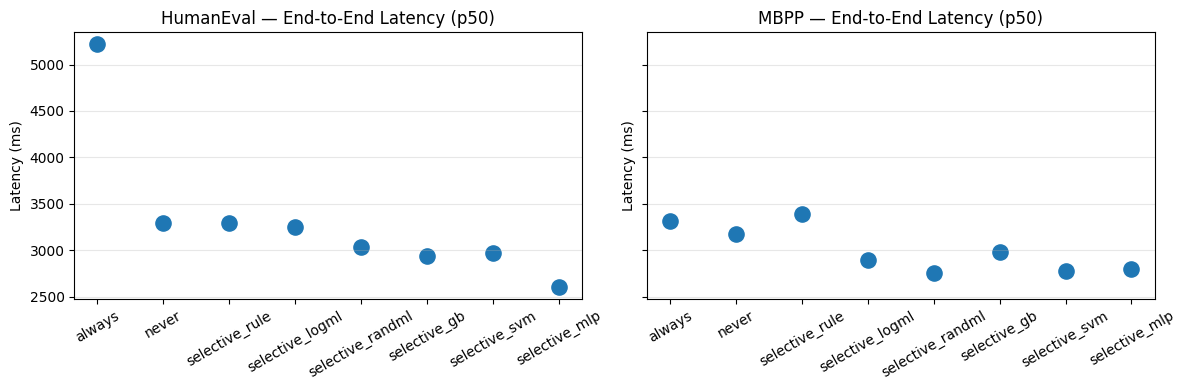

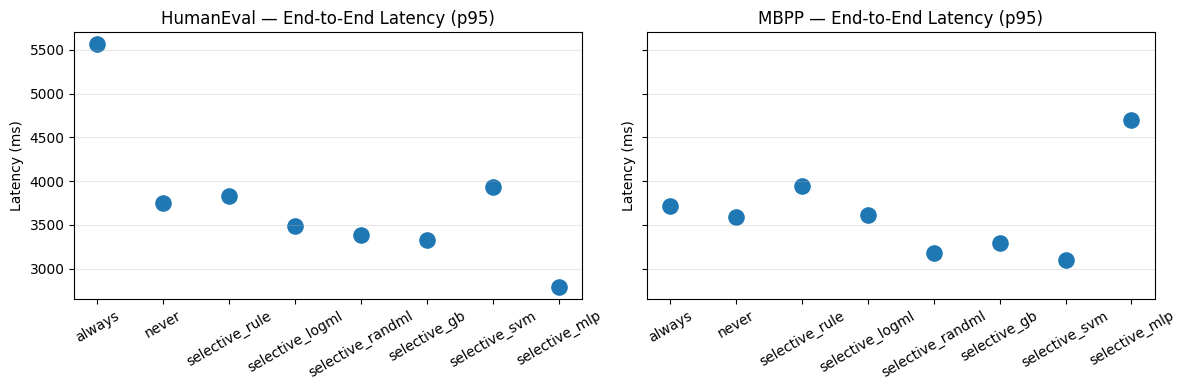

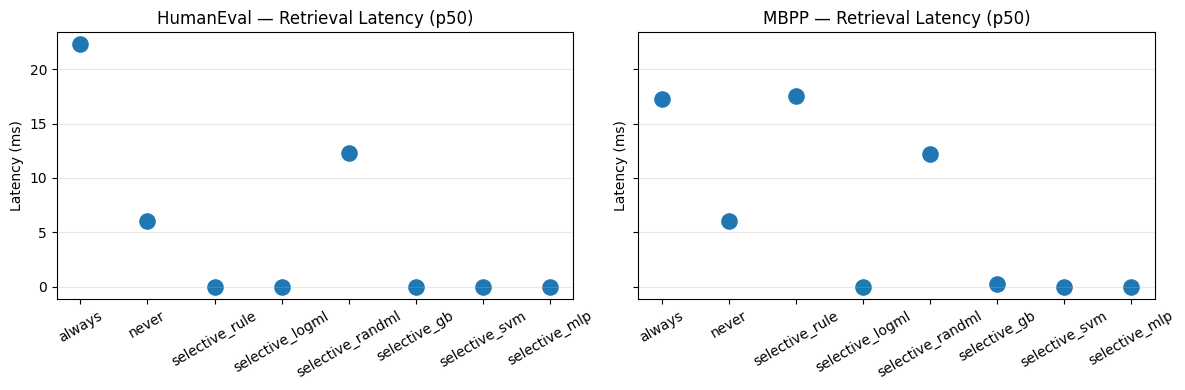

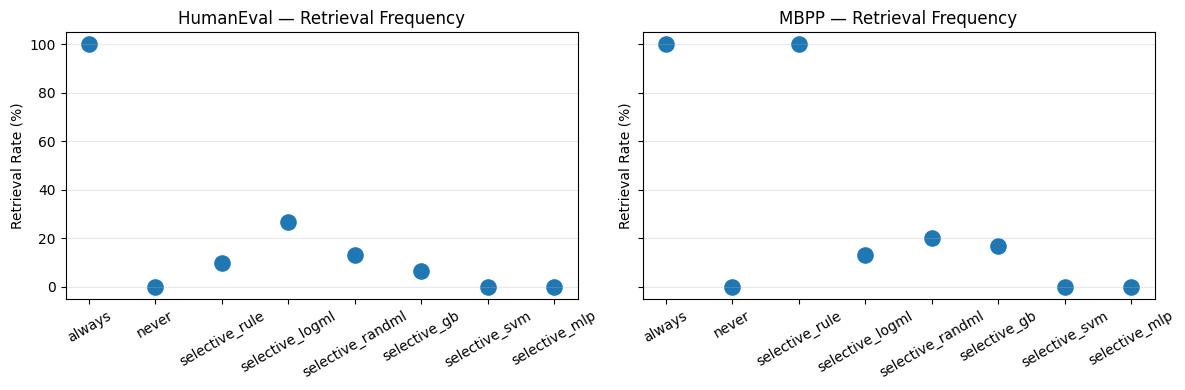

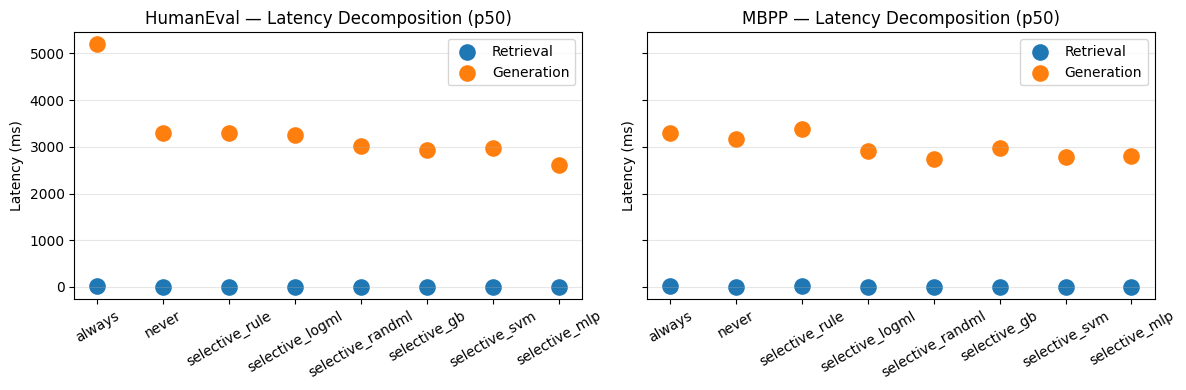

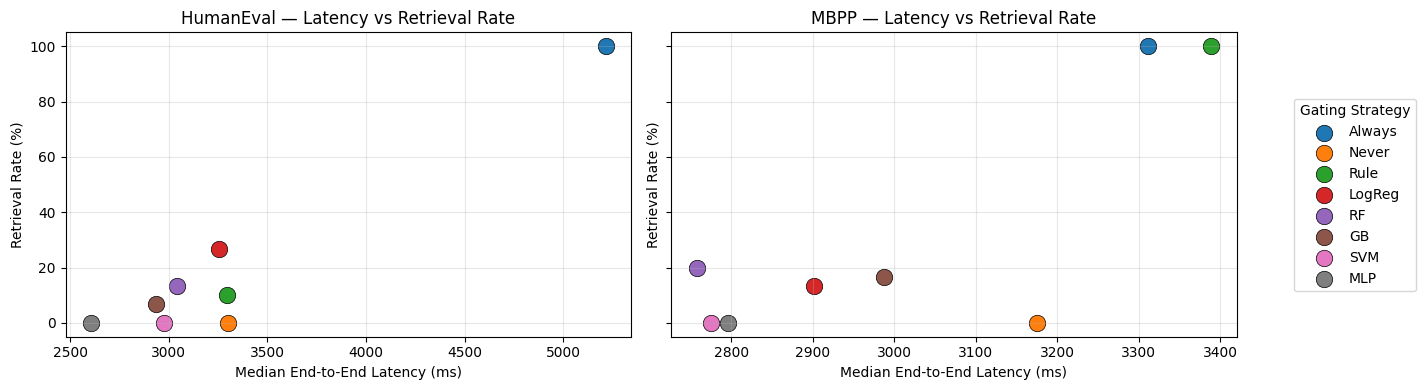

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


df = pd.read_csv("benchmark_results_ml.csv")

MODES = [
    "always",
    "never",
    "selective_rule",
    "selective_logml",
    "selective_randml",
    "selective_gb",
    "selective_svm",
    "selective_mlp",
]
MODE_X = np.arange(len(MODES))


def plot_points(ax, values, title, ylabel):
    ax.scatter(MODE_X, values, s=120)
    ax.set_xticks(MODE_X)
    ax.set_xticklabels(MODES, rotation=30)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True, axis="y", alpha=0.3)


fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

for ax, bench in zip(axes, ["HumanEval", "MBPP"]):
    sub = df[df["benchmark"] == bench]
    p50 = sub.groupby("mode")["latency_e2e"].median().reindex(MODES)
    plot_points(ax, p50.values, f"{bench} — End-to-End Latency (p50)", "Latency (ms)")

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

for ax, bench in zip(axes, ["HumanEval", "MBPP"]):
    sub = df[df["benchmark"] == bench]
    p95 = sub.groupby("mode")["latency_e2e"].quantile(0.95).reindex(MODES)
    plot_points(ax, p95.values, f"{bench} — End-to-End Latency (p95)", "Latency (ms)")

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

for ax, bench in zip(axes, ["HumanEval", "MBPP"]):
    sub = df[df["benchmark"] == bench]
    p50 = sub.groupby("mode")["latency_retrieval"].median().reindex(MODES)
    plot_points(ax, p50.values, f"{bench} — Retrieval Latency (p50)", "Latency (ms)")

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

for ax, bench in zip(axes, ["HumanEval", "MBPP"]):
    sub = df[df["benchmark"] == bench]
    freq = sub.groupby("mode")["retrieved"].mean().reindex(MODES) * 100
    plot_points(ax, freq.values, f"{bench} — Retrieval Frequency", "Retrieval Rate (%)")

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

for ax, bench in zip(axes, ["HumanEval", "MBPP"]):
    sub = df[df["benchmark"] == bench]

    gate_lat = sub.groupby("mode")["gate_time"].median().reindex(MODES)
    ret_lat  = sub.groupby("mode")["retrieval_time"].median().reindex(MODES)
    gen_lat  = sub.groupby("mode")["generation_time"].median().reindex(MODES)

    ax.scatter(MODE_X, ret_lat.values, s=120, label="Retrieval")
    ax.scatter(MODE_X, gen_lat.values, s=120, label="Generation")

    ax.set_xticks(MODE_X)
    ax.set_xticklabels(MODES, rotation=30)
    ax.set_title(f"{bench} — Latency Decomposition (p50)")
    ax.set_ylabel("Latency (ms)")
    ax.legend()
    ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)


LABELS = {
    "always": "Always",
    "never": "Never",
    "selective_rule": "Rule",
    "selective_logml": "LogReg",
    "selective_randml": "RF",
    "selective_gb": "GB",
    "selective_svm": "SVM",
    "selective_mlp": "MLP",
}


COLORS = {
    "always": "tab:blue",
    "never": "tab:orange",
    "selective_rule": "tab:green",
    "selective_logml": "tab:red",
    "selective_randml": "tab:purple",
    "selective_gb": "tab:brown",
    "selective_svm": "tab:pink",
    "selective_mlp": "tab:gray",
}

for ax, bench in zip(axes, ["HumanEval", "MBPP"]):
    sub = df[df["benchmark"] == bench]

    lat = sub.groupby("mode")["latency_e2e"].median()
    freq = sub.groupby("mode")["retrieved"].mean() * 100

    for m in MODES:
        if m not in lat or m not in freq:
            continue

        ax.scatter(
            lat[m],
            freq[m],
            s=140,
            color=COLORS[m],
            label=LABELS[m],
            edgecolors="black",
            linewidths=0.5,
        )

    ax.set_title(f"{bench} — Latency vs Retrieval Rate")
    ax.set_xlabel("Median End-to-End Latency (ms)")
    ax.set_ylabel("Retrieval Rate (%)")
    ax.grid(True, alpha=0.3)


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="center right",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    title="Gating Strategy"
)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

plt.tight_layout()
plt.show()


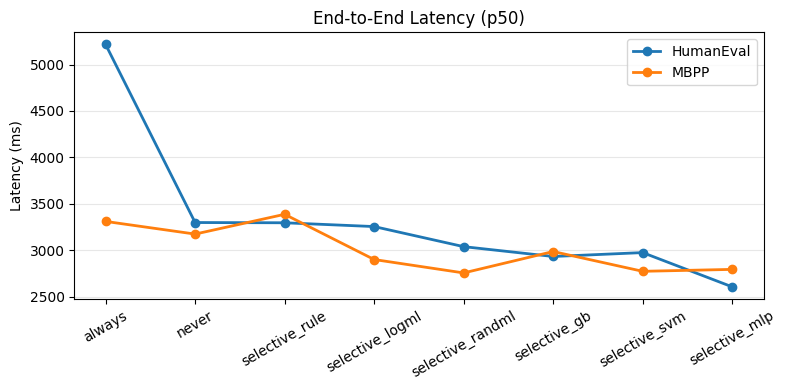

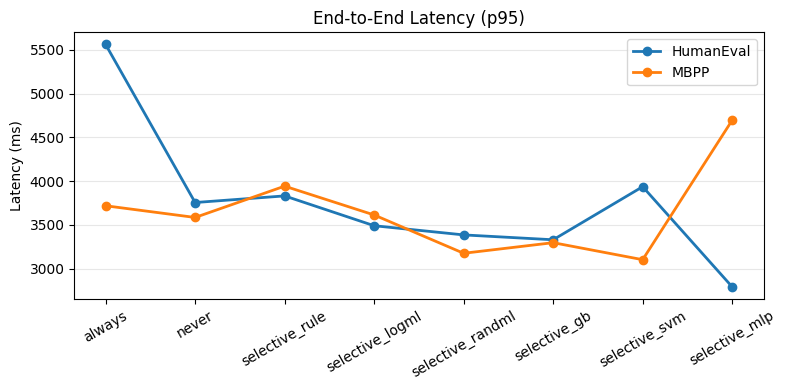

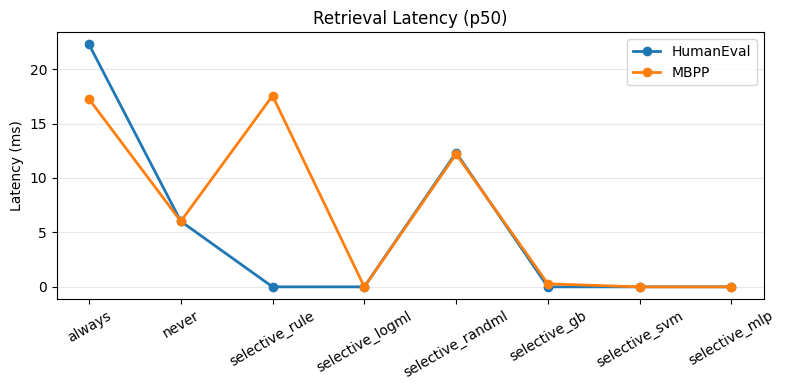

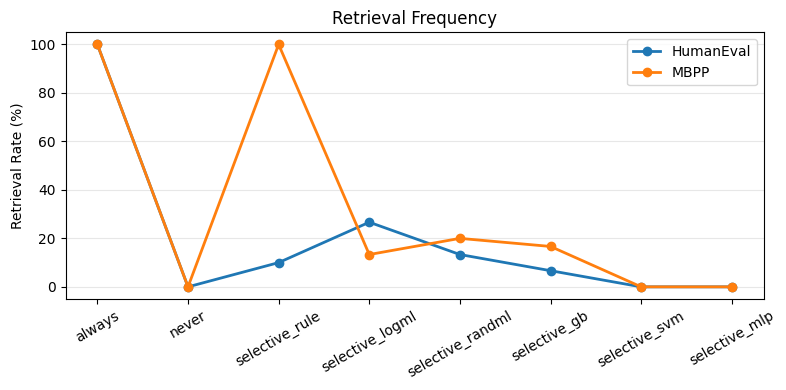

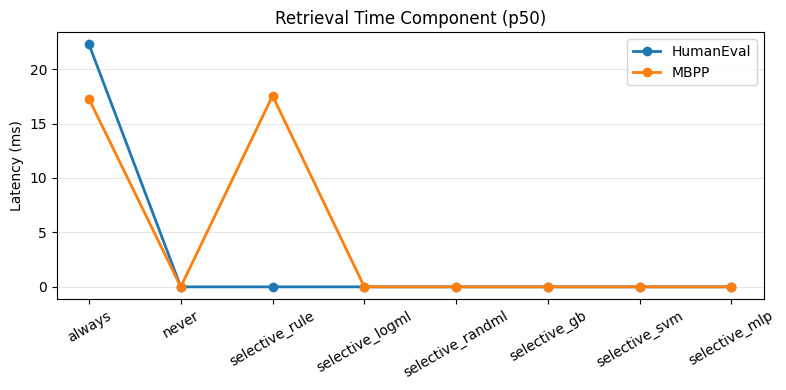

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


df = pd.read_csv("benchmark_results_ml.csv")

MODES = [
    "always",
    "never",
    "selective_rule",
    "selective_logml",
    "selective_randml",
    "selective_gb",
    "selective_svm",
    "selective_mlp",
]

MODE_X = np.arange(len(MODES))

COLORS = {
    "HumanEval": "tab:blue",
    "MBPP": "tab:orange",
}


def plot_he_mbpp(ax, he_vals, mbpp_vals, title, ylabel):
    ax.plot(
        MODE_X,
        he_vals,
        marker="o",
        linewidth=2,
        color=COLORS["HumanEval"],
        label="HumanEval",
    )
    ax.plot(
        MODE_X,
        mbpp_vals,
        marker="o",
        linewidth=2,
        color=COLORS["MBPP"],
        label="MBPP",
    )

    ax.set_xticks(MODE_X)
    ax.set_xticklabels(MODES, rotation=30)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend()


fig, ax = plt.subplots(figsize=(8,4))

he = df[df["benchmark"] == "HumanEval"].groupby("mode")["latency_e2e"].median().reindex(MODES)
mbpp = df[df["benchmark"] == "MBPP"].groupby("mode")["latency_e2e"].median().reindex(MODES)

plot_he_mbpp(ax, he.values, mbpp.values, "End-to-End Latency (p50)", "Latency (ms)")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(8,4))

he = df[df["benchmark"] == "HumanEval"].groupby("mode")["latency_e2e"].quantile(0.95).reindex(MODES)
mbpp = df[df["benchmark"] == "MBPP"].groupby("mode")["latency_e2e"].quantile(0.95).reindex(MODES)

plot_he_mbpp(ax, he.values, mbpp.values, "End-to-End Latency (p95)", "Latency (ms)")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(8,4))

he = df[df["benchmark"] == "HumanEval"].groupby("mode")["latency_retrieval"].median().reindex(MODES)
mbpp = df[df["benchmark"] == "MBPP"].groupby("mode")["latency_retrieval"].median().reindex(MODES)

plot_he_mbpp(ax, he.values, mbpp.values, "Retrieval Latency (p50)", "Latency (ms)")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(8,4))

he = df[df["benchmark"] == "HumanEval"].groupby("mode")["retrieved"].mean().reindex(MODES) * 100
mbpp = df[df["benchmark"] == "MBPP"].groupby("mode")["retrieved"].mean().reindex(MODES) * 100

plot_he_mbpp(ax, he.values, mbpp.values, "Retrieval Frequency", "Retrieval Rate (%)")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(8,4))

he = df[df["benchmark"] == "HumanEval"].groupby("mode")["retrieval_time"].median().reindex(MODES)
mbpp = df[df["benchmark"] == "MBPP"].groupby("mode")["retrieval_time"].median().reindex(MODES)

plot_he_mbpp(ax, he.values, mbpp.values, "Retrieval Time Component (p50)", "Latency (ms)")
plt.tight_layout()
plt.show()


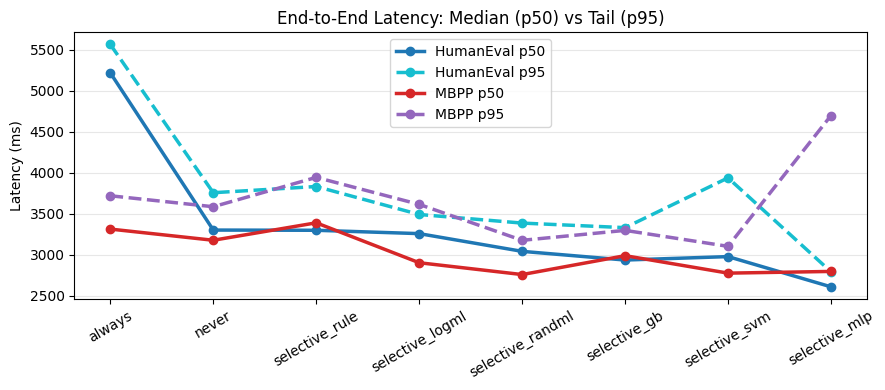

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


df = pd.read_csv("benchmark_results_ml.csv")

MODES = [
    "always",
    "never",
    "selective_rule",
    "selective_logml",
    "selective_randml",
    "selective_gb",
    "selective_svm",
    "selective_mlp",
]

MODE_X = np.arange(len(MODES))


COLORS = {
    "HumanEval_p50": "#1f77b4",  
    "HumanEval_p95": "#17becf",  
    "MBPP_p50": "#d62728",       
    "MBPP_p95": "#9467bd",       
}


fig, ax = plt.subplots(figsize=(9, 4))


he = df[df["benchmark"] == "HumanEval"]
he_p50 = he.groupby("mode")["latency_e2e"].median().reindex(MODES)
he_p95 = he.groupby("mode")["latency_e2e"].quantile(0.95).reindex(MODES)

ax.plot(
    MODE_X,
    he_p50.values,
    marker="o",
    linestyle="-",
    linewidth=2.5,
    color=COLORS["HumanEval_p50"],
    label="HumanEval p50",
)

ax.plot(
    MODE_X,
    he_p95.values,
    marker="o",
    linestyle="--",
    linewidth=2.5,
    color=COLORS["HumanEval_p95"],
    label="HumanEval p95",
)


mb = df[df["benchmark"] == "MBPP"]
mb_p50 = mb.groupby("mode")["latency_e2e"].median().reindex(MODES)
mb_p95 = mb.groupby("mode")["latency_e2e"].quantile(0.95).reindex(MODES)

ax.plot(
    MODE_X,
    mb_p50.values,
    marker="o",
    linestyle="-",
    linewidth=2.5,
    color=COLORS["MBPP_p50"],
    label="MBPP p50",
)

ax.plot(
    MODE_X,
    mb_p95.values,
    marker="o",
    linestyle="--",
    linewidth=2.5,
    color=COLORS["MBPP_p95"],
    label="MBPP p95",
)


ax.set_xticks(MODE_X)
ax.set_xticklabels(MODES, rotation=30)
ax.set_ylabel("Latency (ms)")
ax.set_title("End-to-End Latency: Median (p50) vs Tail (p95)")
ax.grid(True, axis="y", alpha=0.3)
ax.legend(frameon=True)

plt.tight_layout()
plt.show()


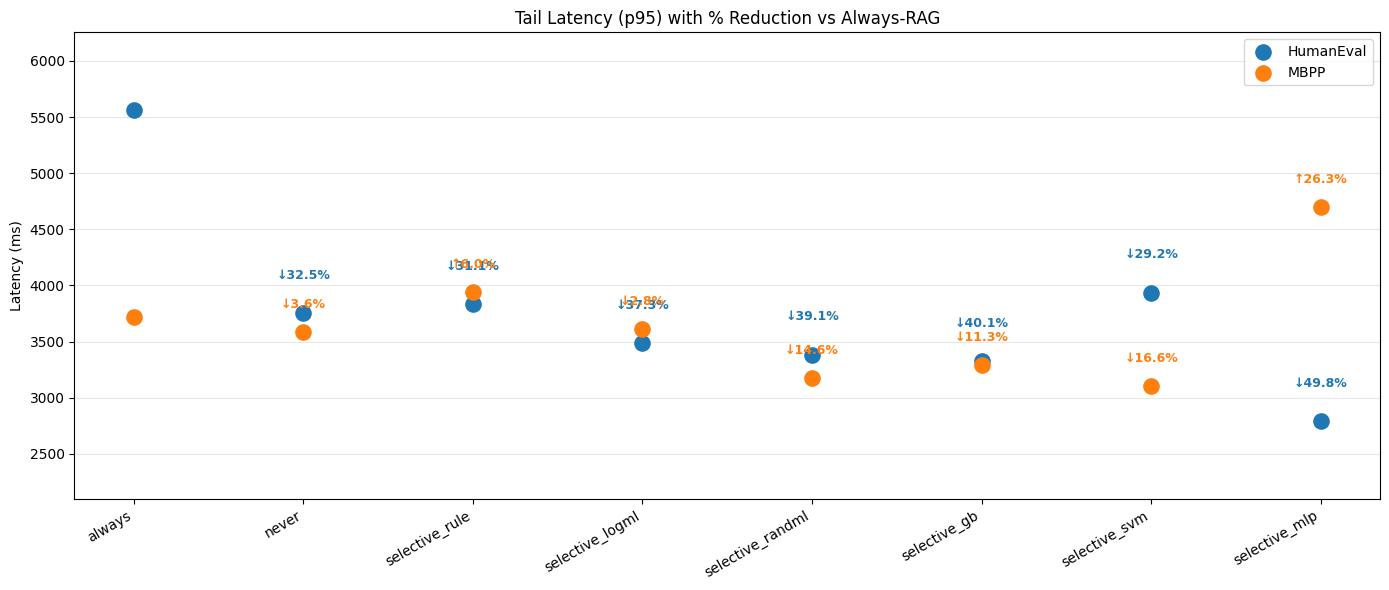

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


df = pd.read_csv("benchmark_results_ml.csv")

LATENCY_COL = "latency_e2e"

MODES = [
    "always",
    "never",
    "selective_rule",
    "selective_logml",
    "selective_randml",
    "selective_gb",
    "selective_svm",
    "selective_mlp",
]

BENCHMARKS = ["HumanEval", "MBPP"]
COLORS = {
    "HumanEval": "tab:blue",
    "MBPP": "tab:orange"
}

def percent_reduction(baseline, value):
    if baseline == 0 or pd.isna(baseline) or pd.isna(value):
        return np.nan
    return ((baseline - value) / baseline) * 100


rows = []

for bench in BENCHMARKS:
    sub = df[df["benchmark"] == bench]
    if sub.empty:
        continue

    p95 = sub.groupby("mode")[LATENCY_COL].quantile(0.95).reindex(MODES)
    baseline = p95.loc["always"]

    for mode in MODES:
        val = p95.loc[mode]
        red = percent_reduction(baseline, val)

        rows.append({
            "benchmark": bench,
            "mode": mode,
            "p95_ms": val,
            "reduction_pct": red
        })

reduction_df = pd.DataFrame(rows)


fig, ax = plt.subplots(figsize=(14, 6))
MODE_X = np.arange(len(MODES))

for bench in BENCHMARKS:
    bench_df = reduction_df[reduction_df["benchmark"] == bench].set_index("mode")
    values = bench_df["p95_ms"].reindex(MODES)

    ax.scatter(
        MODE_X,
        values,
        s=120,
        label=bench,
        color=COLORS[bench],
        zorder=3
    )

    baseline = bench_df.loc["always", "p95_ms"]

    for i, mode in enumerate(MODES):
        if mode == "always":
            continue

        val = bench_df.loc[mode, "p95_ms"]
        pct = bench_df.loc[mode, "reduction_pct"]

        if pd.isna(val) or pd.isna(pct):
            continue

        arrow = "↓" if pct > 0 else "↑"
        text_color = COLORS[bench]  

        ax.text(
    i,
    val + baseline * 0.05,
    f"{arrow}{abs(pct):.1f}%",
    ha="center",
    va="bottom",
    fontsize=9,
    fontweight="bold",
    color=COLORS[bench],  
    zorder=4
)

ax.set_xticks(MODE_X)
ax.set_xticklabels(MODES, rotation=30, ha="right")
ax.set_ylabel("Latency (ms)")
ax.set_title("Tail Latency (p95) with % Reduction vs Always-RAG")
ax.grid(True, axis="y", alpha=0.3)
ax.legend()
ax.margins(y=0.25)

plt.tight_layout()
plt.show()


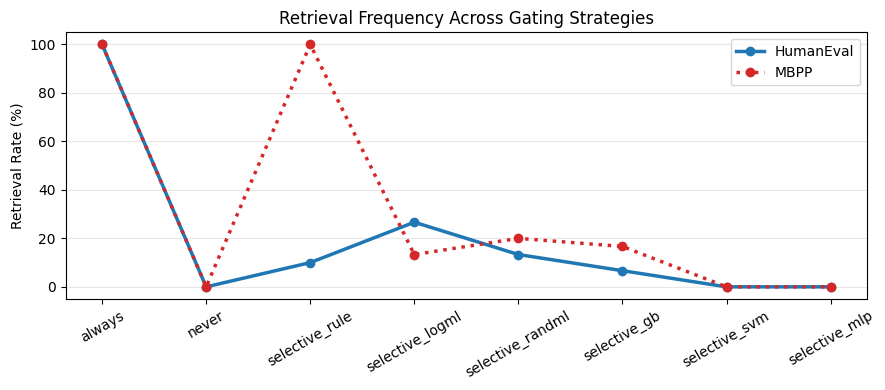

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


df = pd.read_csv("benchmark_results_ml.csv")

MODES = [
    "always",
    "never",
    "selective_rule",
    "selective_logml",
    "selective_randml",
    "selective_gb",
    "selective_svm",
    "selective_mlp",
]

MODE_X = np.arange(len(MODES))


COLORS = {
    "HumanEval": "#1f77b4",  
    "MBPP": "#d62728",      
}


he = (
    df[df["benchmark"] == "HumanEval"]
    .groupby("mode")["retrieved"]
    .mean()
    .reindex(MODES) * 100
)

mbpp = (
    df[df["benchmark"] == "MBPP"]
    .groupby("mode")["retrieved"]
    .mean()
    .reindex(MODES) * 100
)


fig, ax = plt.subplots(figsize=(9, 4))

ax.plot(
    MODE_X,
    he.values,
    marker="o",
    linestyle="-",
    linewidth=2.5,
    color=COLORS["HumanEval"],
    label="HumanEval",
)

ax.plot(
    MODE_X,
    mbpp.values,
    marker="o",
    linestyle=":",
    linewidth=2.5,
    color=COLORS["MBPP"],
    label="MBPP",
)


ax.set_xticks(MODE_X)
ax.set_xticklabels(MODES, rotation=30)
ax.set_ylabel("Retrieval Rate (%)")
ax.set_title("Retrieval Frequency Across Gating Strategies")
ax.grid(True, axis="y", alpha=0.3)
ax.legend(frameon=True)

plt.tight_layout()
plt.show()


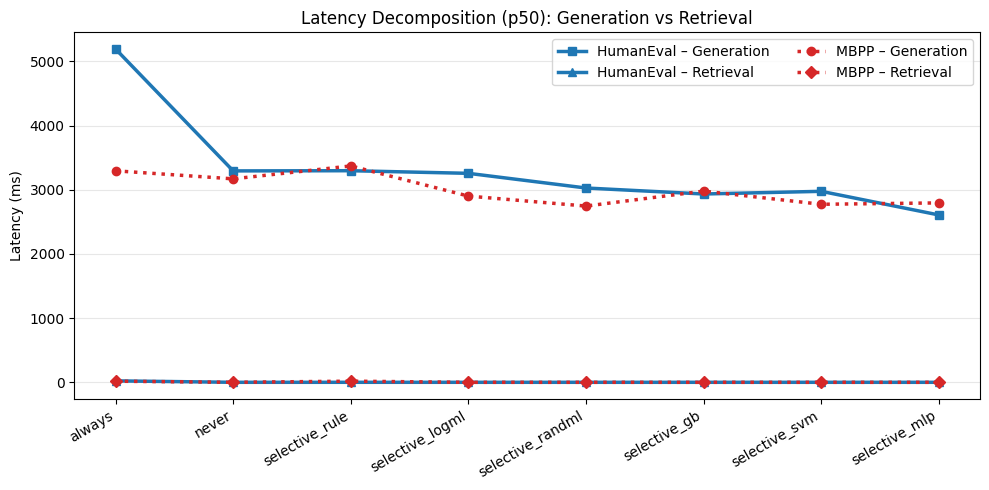

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


df = pd.read_csv("benchmark_results_ml.csv")

MODES = [
    "always",
    "never",
    "selective_rule",
    "selective_logml",
    "selective_randml",
    "selective_gb",
    "selective_svm",
    "selective_mlp",
]

MODE_X = np.arange(len(MODES))


COLORS = {
    "HumanEval": "#1f77b4", 
    "MBPP": "#d62728",      
}


he = df[df["benchmark"] == "HumanEval"]
mbpp = df[df["benchmark"] == "MBPP"]

he_gen = he.groupby("mode")["generation_time"].median().reindex(MODES)
he_ret = he.groupby("mode")["retrieval_time"].median().reindex(MODES)

mbpp_gen = mbpp.groupby("mode")["generation_time"].median().reindex(MODES)
mbpp_ret = mbpp.groupby("mode")["retrieval_time"].median().reindex(MODES)


fig, ax = plt.subplots(figsize=(10, 5))


ax.plot(
    MODE_X,
    he_gen.values,
    marker="s",              
    linestyle="-",
    linewidth=2.5,
    color=COLORS["HumanEval"],
    label="HumanEval – Generation",
)

ax.plot(
    MODE_X,
    he_ret.values,
    marker="^",              
    linestyle="-",
    linewidth=2.5,
    color=COLORS["HumanEval"],
    label="HumanEval – Retrieval",
)

# MBPP — dotted line, circle/diamond markers
ax.plot(
    MODE_X,
    mbpp_gen.values,
    marker="o",              
    linestyle=":",
    linewidth=2.5,
    color=COLORS["MBPP"],
    label="MBPP – Generation",
)

ax.plot(
    MODE_X,
    mbpp_ret.values,
    marker="D",              
    linestyle=":",
    linewidth=2.5,
    color=COLORS["MBPP"],
    label="MBPP – Retrieval",
)


ax.set_xticks(MODE_X)
ax.set_xticklabels(MODES, rotation=30, ha="right")
ax.set_ylabel("Latency (ms)")
ax.set_title("Latency Decomposition (p50): Generation vs Retrieval")
ax.grid(True, axis="y", alpha=0.3)
ax.legend(frameon=True, ncol=2)

plt.tight_layout()
plt.show()
